In [4]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)
    
# print(tf.__version__)

In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = KaggleDatasets().get_gcs_path() + '/chest_xray'
VS_PATH = './dataset_small'
PATH_TRAIN = VS_PATH + '/train/*/*'
PATH_VAL = VS_PATH + '/val/*/*'
PATH_TEST = VS_PATH + '/test/*/*'
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
BATCH_SIZE = 32
# IMAGE_SIZE = [180, 180]
EPOCHS = 10

In [96]:
IMAGE_SIZE = [400, 400]

In [97]:
filenames = tf.io.gfile.glob(str(PATH_TRAIN))
filenames.extend(tf.io.gfile.glob(str(PATH_VAL)))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [98]:
test_filenames = tf.io.gfile.glob(str(PATH_TEST))

In [99]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 323
Pneumonia images count in training set: 329


In [100]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'.\\dataset_small\\train\\PNEUMONIA\\person23_bacteria_96.jpeg'
b'.\\dataset_small\\train\\PNEUMONIA\\person38_bacteria_192.jpeg'
b'.\\dataset_small\\train\\NORMAL\\IM-0297-0001.jpeg'
b'.\\dataset_small\\train\\NORMAL\\IM-0154-0001.jpeg'
b'.\\dataset_small\\train\\PNEUMONIA\\person66_bacteria_323.jpeg'


In [101]:
# test_list_ds = tf.data.Dataset.list_files(str(PATH_TEST))
# TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
# test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE)

# TEST_IMAGE_COUNT
# test_ds

In [102]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))


TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Validating images count: " + str(TEST_IMG_COUNT))

Training images count: 652
Validating images count: 164
Validating images count: 624


In [103]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(PATH_TRAIN))])
CLASS_NAMES

array(['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg',
       'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg', 'IM-0127-0001.jpeg',
       'IM-0128-0001.jpeg', 'IM-0129-0001.jpeg', 'IM-0131-0001.jpeg',
       'IM-0133-0001.jpeg', 'IM-0135-0001.jpeg', 'IM-0137-0001.jpeg',
       'IM-0140-0001.jpeg', 'IM-0141-0001.jpeg', 'IM-0143-0001.jpeg',
       'IM-0145-0001.jpeg', 'IM-0147-0001.jpeg', 'IM-0149-0001.jpeg',
       'IM-0151-0001.jpeg', 'IM-0152-0001.jpeg', 'IM-0154-0001.jpeg',
       'IM-0156-0001.jpeg', 'IM-0158-0001.jpeg', 'IM-0160-0001.jpeg',
       'IM-0162-0001.jpeg', 'IM-0164-0001.jpeg', 'IM-0166-0001.jpeg',
       'IM-0168-0001.jpeg', 'IM-0170-0001.jpeg', 'IM-0172-0001.jpeg',
       'IM-0176-0001.jpeg', 'IM-0177-0001.jpeg', 'IM-0178-0001.jpeg',
       'IM-0180-0001.jpeg', 'IM-0182-0001.jpeg', 'IM-0183-0001.jpeg',
       'IM-0185-0001.jpeg', 'IM-0187-0001.jpeg', 'IM-0189-0001.jpeg',
       'IM-0191-0001.jpeg', 'IM-0193-0001.jpeg', 'IM-0195-0001.jpeg',
       'IM-0199-0001

In [104]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [105]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [106]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (400, 400, 3)
Label:  True


In [107]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [108]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_training(test_ds)

image_batch, label_batch = next(iter(train_ds))

In [109]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

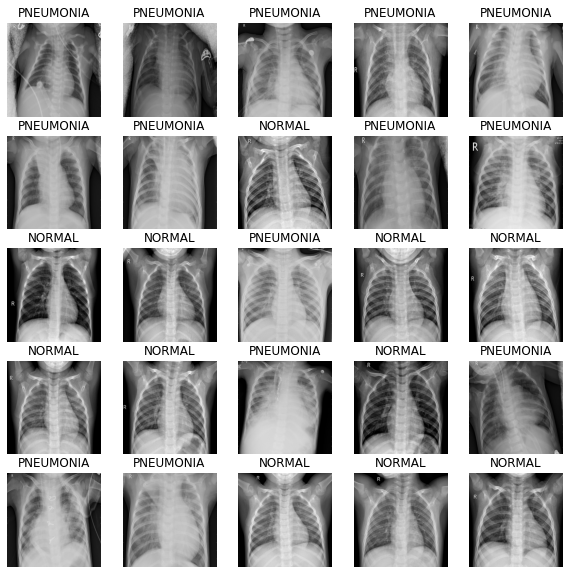

In [110]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [66]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [67]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([0.04908961])

In [68]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

final_bias = np.log([weight_for_1 * COUNT_PNEUMONIA/weight_for_0 * COUNT_NORMAL])
print('Final bias: ', final_bias)

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Final bias:  [11.52410277]
Weight for class 0: 1.03
Weight for class 1: 0.98


In [69]:
# with strategy.scope():
#     model = build_model()

#     METRICS = [
#         'accuracy',
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')
#     ]
    
#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=METRICS
#     )


model = build_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [70]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/10
20/20 [==============================] - 78s 4s/step - loss: 0.4918 - accuracy: 0.7703 - precision: 0.7830 - recall: 0.7615 - val_loss: 0.6933 - val_accuracy: 0.5437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 76s 4s/step - loss: 0.2722 - accuracy: 0.8984 - precision: 0.9204 - recall: 0.8784 - val_loss: 0.6930 - val_accuracy: 0.5437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 75s 4s/step - loss: 0.1808 - accuracy: 0.9359 - precision: 0.9385 - recall: 0.9356 - val_loss: 0.6896 - val_accuracy: 0.5437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 72s 4s/step - loss: 0.1390 - accuracy: 0.9453 - precision: 0.9630 - recall: 0.9313 - val_loss: 0.7015 - val_accuracy: 0.4437 - val_precision: 0.4437 - val_recall: 1.0000
Epoch 5/10
20/20 [==============================] - 72s 4s/step - loss: 0.1517 - accurac

In [71]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [72]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [74]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=10,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/10
20/20 [==============================] - 79s 4s/step - loss: 0.1118 - accuracy: 0.9672 - precision: 0.9637 - recall: 0.9726 - val_loss: 0.8225 - val_accuracy: 0.7937 - val_precision: 0.6900 - val_recall: 0.9718 - lr: 0.0100
Epoch 2/10
20/20 [==============================] - 73s 4s/step - loss: 0.0871 - accuracy: 0.9656 - precision: 0.9840 - recall: 0.9477 - val_loss: 0.3677 - val_accuracy: 0.9375 - val_precision: 0.9559 - val_recall: 0.9028 - lr: 0.0089
Epoch 3/10
20/20 [==============================] - 83s 4s/step - loss: 0.0896 - accuracy: 0.9641 - precision: 0.9608 - recall: 0.9696 - val_loss: 2.4419 - val_accuracy: 0.4750 - val_precision: 0.4581 - val_recall: 1.0000 - lr: 0.0079
Epoch 4/10
20/20 [==============================] - 79s 4s/step - loss: 0.0832 - accuracy: 0.9672 - precision: 0.9690 - recall: 0.9660 - val_loss: 0.9585 - val_accuracy: 0.7125 - val_precision: 0.6121 - val_recall: 0.9861 - lr: 0.0071
Epoch 5/10
20/20 [==============================] - 73s 4s/s

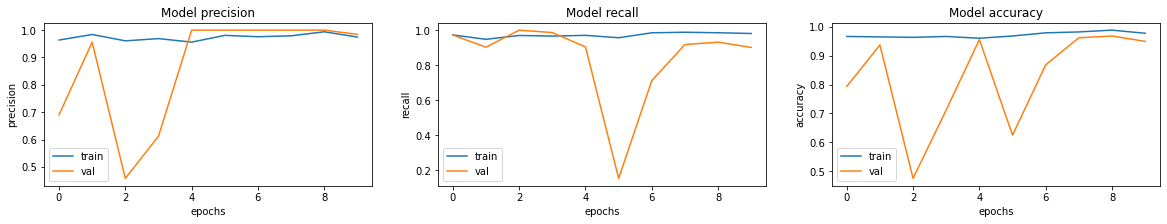

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [111]:
loss, acc, prec, rec = model.evaluate(test_ds)

ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).

In [91]:
test_ds.labels

AttributeError: 'BatchDataset' object has no attribute 'labels'

In [78]:
preds = model.predict(test_ds)
test_labels = np.argmax(test_ds, axis=1)

cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history['accuracy'][-1])*100, 2)))

AxisError: axis 1 is out of bounds for array of dimension 1

### X - Compare

In [1]:
x100 = {'loss': 1.0014, 'acc': 0.7756, 'prec': 0.7367, 'rec': 0.9974}
x150 = {'loss': 0.7766, 'acc': 0.8125, 'prec': 0.7725, 'rec': 0.9923}
x200 = {'loss': 1.1774, 'acc': 0.7804, 'prec': 0.7437, 'rec': 0.9897}
x400 = {'loss': 0.9999, 'acc': 0.7772, 'prec': 0.7390, 'rec': 0.9949}
x600 = {'loss': 1.1815, 'acc': 0.7596, 'prec': 0.7239, 'rec': 0.9949}

compare = {'100x100': x100, '150x150': x150, '200x200': x200, '400x400': x400, '600x600': x600,}

In [2]:
compare

{'100x100': {'loss': 1.0014, 'acc': 0.7756, 'prec': 0.7367, 'rec': 0.9974},
 '150x150': {'loss': 0.7766, 'acc': 0.8125, 'prec': 0.7725, 'rec': 0.9923},
 '200x200': {'loss': 1.1774, 'acc': 0.7804, 'prec': 0.7437, 'rec': 0.9897},
 '400x400': {'loss': 0.9999, 'acc': 0.7772, 'prec': 0.739, 'rec': 0.9949},
 '600x600': {'loss': 1.1815, 'acc': 0.7596, 'prec': 0.7239, 'rec': 0.9949}}

In [6]:
df = pd.DataFrame(data=compare)
df

,100x100,150x150,200x200,400x400,600x600
loss,1.0014,0.7766,1.1774,0.9999,1.1815
acc,0.7756,0.8125,0.7804,0.7772,0.7596
prec,0.7367,0.7725,0.7437,0.7390,0.7239
rec,0.9974,0.9923,0.9897,0.9949,0.9949
